### Overlapping Segmentation for Improved Spike Detection in Neural Data

To address the reviewer's question about the segmentation please consider that regardless of the overlap mechanism we implement between segments, some segments may require more overlap while others need less. So precisely determining the necessary overlap for each segment might not be feasible. On the other hand, we aim to avoid adding complex components and calculations to the algorithm to maintain its speed for real-time applications and to ensure it is suitable for future hardware implementations. Therefore, in response to the reviewer's point, we have crafted a part of the algorithm to determine the optimal segmentation size for the given data, utilizing its characteristics and minimizing overlap loss as much as possible. We have made this section optional, allowing for flexibility in cases where speed is prioritized over comprehensive sorting in the design or sorting process.
To address this issue, we approached it in two sections: a rapid performance assessment and determination of the optimal segment size.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd


### 1) A Performance Test: 

Segment overlapping can be used to address spike duplications among neighbor segments. However, we did not find segmentation overlaps significantly affect the number of correlated spikes extracted from our new synthetic data of reasonable physical spacings among neurons. Below table is an analysis showing the number of correlated spikes found when segmentation overlaps were used and not used (High overlap = 2 channels overlap, Low overlap = 1 channel overlap and segment size = 4 channels). When the neurons are sparsely spaced causing neural signals spreading across a large portion of the channels, according to the analysis below, further overlapping the channels may not give a significant benefits to justify the additional computation costs required. These findings emphasize that the data structure or probe configuration significantly influences the effectiveness of the overlap strategy.

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

path = '/Users/zm6112/Dropbox (Princeton)/PHD_paper_material/Journal of \
neural engineering review/New figures/' + 'Overlap_segmentation/'

# Define data parameters
data_length = 10000
num_channels = 16

# Create synthetic spike data with noise
spike_data = np.random.randn(data_length, num_channels)
spike_amplitude = 5  
spike_duration = 50 
for i in range(200):  
    spike_time = np.random.randint(0, data_length - spike_duration)
    spike_channels = np.random.choice(num_channels, size=3, replace=False)  
    spike_profile = np.sin(np.linspace(0, np.pi, spike_duration)) * spike_amplitude
    for channel in spike_channels:
        spike_data[spike_time:(spike_time + spike_duration), channel] += spike_profile

# Function to segment data based on number of channels with optional overlap
def segment_data_by_channels(data, segment_channel_size, overlap_channels):
    segments = []
    start_channel = 0
    while start_channel + segment_channel_size <= num_channels:
        end_channel = start_channel + segment_channel_size + overlap_channels
        end_channel = end_channel if end_channel <= num_channels else num_channels
        segments.append(data[:, start_channel:end_channel])
        start_channel += segment_channel_size
    return segments

def detect_spikes(segments, threshold=3.5): 
    spike_counts = 0
    debounce_time = 60
    for segment in segments:
        for i in range(debounce_time, segment.shape[0] - debounce_time, debounce_time):
            max_amplitude = np.max(np.abs(segment[i-debounce_time:i+debounce_time]))
            if max_amplitude > threshold:
                spike_counts += 1
    return spike_counts


segment_channel_size = 4

# Define high overlap 
overlap_channels = 2  

segments_without_overlap = segment_data_by_channels(spike_data, segment_channel_size, 0)
segments_with_overlap = segment_data_by_channels(spike_data, segment_channel_size, overlap_channels)
spikes_detected_without_overlap = detect_spikes(segments_without_overlap)
spikes_detected_with_overlap = detect_spikes(segments_with_overlap)

if spikes_detected_without_overlap > 0:
    proportional_increase = ((spikes_detected_with_overlap - spikes_detected_without_overlap) / spikes_detected_without_overlap) * 100
else:
    proportional_increase = "undefined"  

# Print results
print(f"Spikes detected without overlap: {spikes_detected_without_overlap}")
print(f"Spikes detected with overlap: {spikes_detected_with_overlap}")
print(f"Proportional increase in spike detection with overlap: {proportional_increase}%")

# Define low overlap 
overlap_channels = 1  

segments_without_overlap = segment_data_by_channels(spike_data, segment_channel_size, 0)
segments_with_overlap = segment_data_by_channels(spike_data, segment_channel_size, overlap_channels)
spikes_detected_without_overlap = detect_spikes(segments_without_overlap)
spikes_detected_with_overlap = detect_spikes(segments_with_overlap)

if spikes_detected_without_overlap > 0:
    proportional_increase = ((spikes_detected_with_overlap - spikes_detected_without_overlap) / spikes_detected_without_overlap) * 100
else:
    proportional_increase = "undefined"  

# Print results
print(f"Spikes detected without overlap: {spikes_detected_without_overlap}")
print(f"Spikes detected with overlap: {spikes_detected_with_overlap}")
print(f"Proportional increase in spike detection with overlap: {proportional_increase}%")

Spikes detected without overlap: 582
Spikes detected with overlap: 614
Proportional increase in spike detection with overlap: 5.498281786941581%
Spikes detected without overlap: 582
Spikes detected with overlap: 599
Proportional increase in spike detection with overlap: 2.9209621993127146%


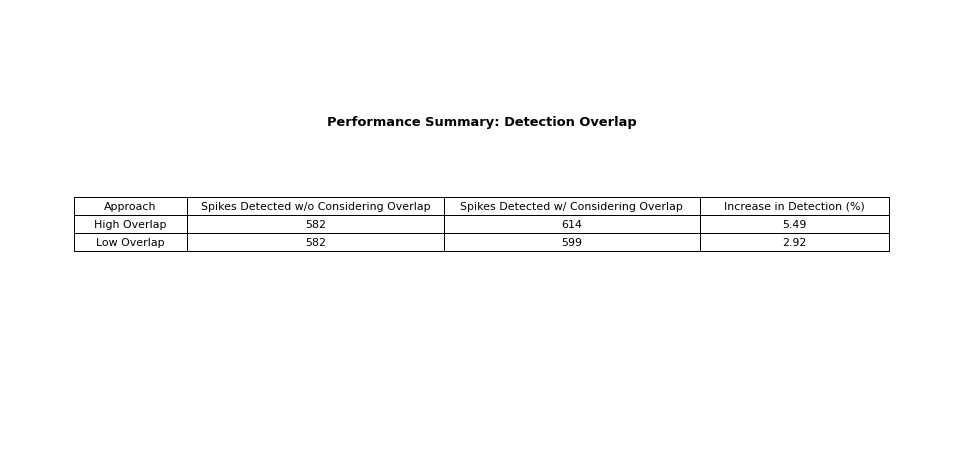

In [3]:


# Create DataFrame
data = {
    'Approach': ["High Overlap", "Low Overlap"],
    'Spikes Detected w/o Considering Overlap': [582, 582],
    'Spikes Detected w/ Considering Overlap': [614, 599],
    'Increase in Detection (%)': [5.49, 2.92]
}
df = pd.DataFrame(data)

# Save the DataFrame to a PDF file
with PdfPages(path + "/overlap_performance.pdf") as pdf:
    fig, ax = plt.subplots(figsize=(17, 8))  # Adjust the figsize as needed
    ax.axis('tight')
    ax.axis('off')
    
    col_widths = [0.12, 0.27, 0.27, 0.2]  # Adjust widths to fit your needs

    # Create the table
    table = ax.table(cellText=df.values, colLabels=df.columns, loc='center', 
                     cellLoc='center', colWidths=col_widths)  # cellLoc for text alignment
    table.auto_set_font_size(False)
    table.set_fontsize(11)  # Set the font size for the table
    table.scale(1, 1.5)  # Adjust table scale
    ax.text(0.5, .75, 'Performance Summary: Detection Overlap', transform=ax.transAxes,
        fontsize=13, fontweight='bold', va='top', ha='center')

    # Adjust layout to make sure the table is within the figure area
#     plt.tight_layout()

#     pdf.savefig(fig, bbox_inches='tight')
#     plt.close()
    plt.show()


### 2) Finding best segment size: 

We enhanced our algorithm by adding an optimization component to better manage overlap detection, adapting to the data characteristics. This involved simulations to identify the optimal segment size that captures overlaps without redundancy. Our tests used a grid of 64 channels across 1000 time points, focusing on segment sizes that best detect correlated spikes, under two different scenarios.

In the first scenario, we tailored the synthetic data to predominantly capture correlated spikes using a segment size of 6. We used a function to assess each potential segment size from 2 to 32 channels, evaluating correlated spike counts across segments. The analysis, depicted in the upper plot of the figure below, highlights how correlated spike counts vary with segment size, revealing the spatial dynamics of spike correlation. Based on this, we chose a segment size of 6, which showed the highest count of correlated spikes, consistent with our data generation parameters.


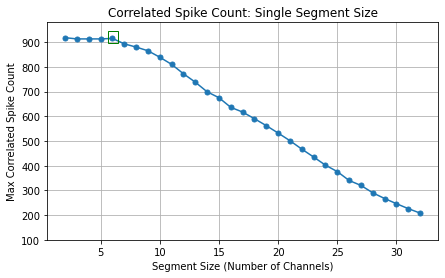

In [4]:
# Parameters
num_channels = 64
num_time_points = 1000
correlated_block_start = 29  
correlated_block_size = 6
correlation_probability_high = 0.2  
spike_duration = 20  
jitter_high = 2  

# Initialize spike matrix
spike_matrix = np.zeros((num_channels, num_time_points))

def gaussian_waveform(center, length=20, height=1):
    x = np.arange(0, length)
    sigma = length / 6 
    return height * np.exp(-np.power(x - center, 2.) / (2 * np.power(sigma, 2.)))
waveform_center = spike_duration // 2

np.random.seed(42)  # For reproducibility
for t in range(num_time_points):
    if np.random.rand() < correlation_probability_high:
        start_time = t + np.random.randint(-jitter_high, jitter_high + 1)
        waveform = gaussian_waveform(waveform_center, spike_duration)
        for channel in range(correlated_block_start, correlated_block_start + correlated_block_size):
            adjusted_start = max(0, start_time + np.random.randint(-jitter_high, jitter_high + 1))
            adjusted_end = min(num_time_points, adjusted_start + spike_duration)
            if adjusted_end > adjusted_start:  
                adjusted_waveform = waveform[:adjusted_end - adjusted_start]
                spike_matrix[channel, adjusted_start:adjusted_end] += adjusted_waveform

def count_strict_correlated_spikes(data, max_segment_size, threshold=0.5):
    num_channels, num_time_points = data.shape
    max_correlated_counts = []
    for segment_size in range(2, max_segment_size + 1):
        max_count = 0
        for start_channel in range(num_channels - segment_size + 1):
            segment = data[start_channel:start_channel + segment_size, :]
            correlated_spikes = (np.sum(segment, axis=0) >= threshold * segment_size).sum()
            max_count = max(max_count, correlated_spikes)
        max_correlated_counts.append(max_count)
    return max_correlated_counts

strict_correlated_spike_counts = count_strict_correlated_spikes(spike_matrix, num_channels)
plt.figure(figsize=(7, 4))
T= int(num_channels/2) + 1
plt.plot(range(2, T), strict_correlated_spike_counts[0:T-2], marker='o', markersize=5)
plt.xlabel('Segment Size (Number of Channels)')
plt.ylabel('Max Correlated Spike Count')

ax = plt.gca()
highlight_x = 6
highlight_y = strict_correlated_spike_counts[highlight_x-2]

ax.text(highlight_x, highlight_y, ' ', color='red', size=4, 
        bbox=dict(facecolor='none', edgecolor='green'))

plt.title('Correlated Spike Count: Single Segment Size')
plt.grid(True)
plt.ylim(100, 980)
# plt.savefig(path +'Correlated Spike Count: Single Segment Size.pdf')
plt.show()

In the second scenario, we generated synthetic data so that different segment sizes—4, 6, 8, and 9—did capture the highest correlated spikes for various neurons. The result, the lower plot of the figure below, helped us ascertain that a segment size of 9, the largest size that detected the highest count of correlated spikes, was most effective in covering all overlapping spikes across different neuronal configurations and segments.

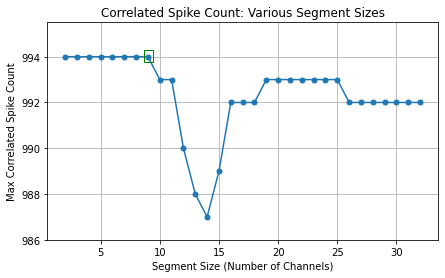

In [5]:

# Parameters
num_channels = 64
num_time_points = 1000
neuron_blocks = [(10, 4), (25, 6), (40, 8), (55, 9)]
correlation_probability_high = 0.5  
spike_duration = 20
jitter_high = 1  

# Initialize spike matrix
spike_matrix = np.zeros((num_channels, num_time_points))
def gaussian_waveform(center, length=20, height=1):
    x = np.arange(0, length)
    sigma = length / 6
    return height * np.exp(-np.power(x - center, 2.) / (2 * np.power(sigma, 2.)))

np.random.seed(42)
for block_start, block_size in neuron_blocks:
    for t in range(num_time_points):
        if np.random.rand() < correlation_probability_high:
            start_time = t + np.random.randint(-jitter_high, jitter_high + 1)
            waveform = gaussian_waveform(spike_duration // 2, spike_duration)
            for channel in range(block_start, block_start + block_size):
                adjusted_start = max(0, start_time)  
                adjusted_end = min(num_time_points, adjusted_start + spike_duration)  
                if adjusted_end > adjusted_start:  
                    adjusted_waveform = waveform[:adjusted_end - adjusted_start]  
                    spike_matrix[channel, adjusted_start:adjusted_end] += adjusted_waveform

def count_correlated_spikes(data, max_segment_size):
    num_channels, num_time_points = data.shape
    max_correlated_counts = []
    for segment_size in range(2, max_segment_size + 1):
        max_count = 0
        for start_channel in range(num_channels - segment_size + 1):
            segment = data[start_channel:start_channel + segment_size, :]
            correlated_spikes = (np.sum(segment, axis=0) >= 0.85 * segment_size).sum()
            max_count = max(max_count, correlated_spikes)
        max_correlated_counts.append(max_count)
    return max_correlated_counts

correlated_spike_counts = count_correlated_spikes(spike_matrix, num_channels)

plt.figure(figsize=(7, 4))
T= int(num_channels/2) + 1
plt.plot(range(2, T), correlated_spike_counts[0:T-2], marker='o', markersize=5)
# plt.xlim(0, 32.2)
ax = plt.gca()
highlight_x = 9
highlight_y = correlated_spike_counts[highlight_x-2]

ax.text(highlight_x, highlight_y, ' ', color='red', size=4, 
        bbox=dict(facecolor='none', edgecolor='green'))
plt.xlabel('Segment Size (Number of Channels)')
plt.ylabel('Max Correlated Spike Count')
plt.title('Correlated Spike Count: Various Segment Sizes')
plt.grid(True)
plt.ylim(986, 995.5)
# plt.savefig(path +'Correlated Spike Count: Various Segment Size.pdf')
plt.show()

Ultimately, the optimal segment size is determined by the highest number of detected correlated spikes, maximizing spike detection efficacy in multi-channel neural data analysis. 

Additionally, even with the optimized segment size, it may be necessary for the user to consider overlap. So users can utilize the code from the first section (performance test) to specify the desired number of overlap channels and assess the resulting performance difference. If the performance improvement is significant, they can opt for that number of overlap channels.
